##  2. Data Preprocessing

### 2.1 Signal Preprocessing For The MIMIC-IV Dataset

# ECG Interpretation Guide

## P-Wave: Atrial Depolarization
- Represents atrial depolarization, the first electrical activity seen on an ECG.
- **Normal duration**: ~80ms (0.08s), typically **less than 120ms**.
- **Normal amplitude**: < 2.5mm in lead II.
- **Morphology**: Smooth and rounded for Monophasic (lead II), biphasic (lead V1)
- **Best seen in leads**: I, II, aVF.
- **Abnormalities**:
  - **Tall/Peaked P-waves (P pulmonale)**: Suggests **right atrial enlargement** (>2.5mm in II, >1.5mm in V1)
  - **Wide/Notched P-waves (P mitrale)**: Suggests **left atrial enlargement** (>120ms) 
  - **Absent P-wave**: Could indicate **atrial fibrillation (AF)** or a junctional rhythm

## (A) QRS Complex: Ventricular Depolarization
- **Narrow/Normal QRS (<100ms):** Supraventricular origin, meaning the impulse originates **above the ventricles** (e.g., from the atria or AV node).
- **Widened QRS (>100ms, >120ms for block):** Indicates a **ventricular origin** or **conduction delay** (e.g., bundle branch block, ventricular pre-excitation, or ventricular tachycardia).

### (A.1) Amplitude of QRS
- **High amplitude**:
  - May suggest **ventricular hypertrophy** (left or right, based on affected leads).
  - **Left Ventricular Hypertrophy (LVH)** criteria: S-wave depth in V1 + R-wave height in V5/V6 > 35mm.
  - **Right Ventricular Hypertrophy (RVH)** criteria: R-wave height in V1 > S-wave depth.
- **Variable amplitude (Electrical alternans)**:
  - Suggests **pericardial effusion** or severe cardiomyopathy.

### (A.2) QRS Wave Components
- **Q-Wave:** First negative deflection **before** an R-wave.
- **R-Wave:** The first **positive** deflection.
- **S-Wave:** Any **negative** deflection following an R-wave.

### (A.3) Pathological Q-Waves Criteria
Pathological Q-waves are **strong indicators of myocardial infarction (MI)** and meet the following criteria:
- Depth **≥ 25%** of the QRS complex or **> 2mm**.
- Duration **> 40ms**.
- Presence in **V1 - V3** suggests anterior infarction.

### (A.4) R-Wave Progression
- **Normal:** R-wave should become **greater than S-wave** around **V3/V4**.
- **Poor R-wave progression:** May indicate **previous anterior myocardial infarction or left ventricular dysfunction**.

## ST-Segment: Interval Between Ventricular Depolarization and Repolarization
- **Normal duration**: Usually **80-120ms**.
- **Elevations (>1mm or 2mm in V1/V2) may indicate:**
  - **ST-Elevation Myocardial Infarction (STEMI)**.
  - **Pericarditis** (diffuse concave ST-elevation, PR depression).
- **Reciprocal ST-Depression:**
  - Seen in **III and aVF** in cases of infarction.
  - **ST-depression is always abnormal** and suggests **ischemia**.
- **ST-segment in Bundle Branch Block (BBB)**:
  - Requires additional criteria (e.g., Sgarbossa criteria in LBBB for MI detection).

### Benign Early Repolarization
- Common in **young, healthy individuals**.
- **Characteristics:**
  - Concave ST-elevation.
  - No reciprocal changes.
  - Not dynamic (remains stable over time).
  - Prominent J-point elevation.

## T-Waves: Ventricular Repolarization
### Normal & Abnormal T-Waves
- **Inverted T-Waves**:
  - **Normal in:** V1, aVR, III.
  - Can persist from **childhood** in some individuals.
  - **V2 and V3 inverted T waves** in the absence of ST changes can be **normal**.
  - **Widespread inverted T-waves** suggest ischemia, left ventricular hypertrophy, or raised intracranial pressure.
- **Tall T-Waves:** May indicate **hyperkalemia**.
- **Biphasic T-Waves:**
  - **Type 1 biphasic:** More negative; seen in **ischemia**.
  - **Type 2 biphasic:** More positive; seen in **hypokalemia**.

## QT-Interval: Ventricular Depolarization to Repolarization
- The QT interval varies with heart rate and requires correction using **Bazett's formula**:
  
  QTc = QT/sqrt(RR)

- **Normal QTc Values:**
  - **Males:** 360ms - 440ms.
  - **Females:** 360ms - 460ms.
- **QTc Prolongation**:
  - Prolonged QT can lead to **Torsades de Pointes**, a potentially fatal ventricular arrhythmia.
  - Causes: Congenital **Long QT Syndrome (LQTS)**, drugs (antiarrhythmics, antidepressants), electrolyte imbalances (hypokalemia, hypocalcemia, hypomagnesemia).

## U-Waves: Post-T-Wave Activity
- Occasionally follows the T-wave, most visible in **V2-V3**.
- **Increased U-wave amplitude**:
  - Electrolyte imbalances (**hypokalemia, hypocalcemia, hypomagnesemia**).
  - **Hypothermia**.
  - **Bradycardia**.

## Heart Rates: Bradycardia and Tachycardia
Heart rate is derived from RR intervals (distance between R-peaks):
  Heart_Rate = 60 / RR_Interval

- **Normal Sinus Rhythm (NSR):** 60-100 BPM
- **Bradycardia:** Heart rate < 60 BPM.
  - Can be normal in well-trained athletes.
  - May indicate **sinus node dysfunction**, heart block, or medication effects.
- **Tachycardia:** Heart rate > 100 BPM.
  - Can be due to physiological stress (exercise, fever) or pathological causes like **supraventricular tachycardia (SVT), atrial fibrillation, or ventricular tachycardia**.
- **Heart Rate Variability (HRV):**
  - High HRV: Indicates good autonomic function
  - Low HRV: Associated with stress, arrhythmias, myocardial infarction

## References
- [Electrocardiography - Wikipedia](https://en.wikipedia.org/wiki/Electrocardiography)
- [ECG Basics YT video](https://youtu.be/u1m3HKW1VqU?si=2qTChCiMFDmWQfUb)

In [8]:
from scipy.signal import find_peaks, butter, filtfilt, detrend
import numpy as np
import scipy.signal as signal
import scipy.fftpack as fft
import matplotlib.pyplot as plt

# For each channel it uses a frequency of 500 Hz
# With a sample count of 5000 samples
# The total time is 10 seconds (duration of the signal)

# Load header & data file
hea_file = "../data/data_bin/40689238.hea"
dat_file = "../data/data_bin/40689238.dat"

# Read the header to extract sampling frequency and scaling factors
with open(hea_file, "r") as f:
    lines = f.readlines()

header_info = lines[0].strip().split()
channel_count = int(header_info[1]) # Number of channels
frequency     = int(header_info[2]) # Sampling frequency (Hz)
sample_count  = int(header_info[3]) # Total samples per channel

# Extract per-channel parameters (scale factors and channel names)
# Each subsequent line corresponds to one channel.
scale_factors = []  # list of scale factors for each lead
channel_names = []  # list of lead names

for i in range(1, channel_count + 1):
    parts = lines[i].strip().split()
    # parts[2] is a string like "200.0(0)/mV". Extract the numeric scale factor.
    scale_factor = float(parts[2].split("(")[0])
    scale_factors.append(scale_factor)

    # The last field is the lead name (e.g., I, II, III, aVR, etc.)
    channel_names.append(parts[-1])

In [9]:
# Read data interpreted as int16 and normalize it converting it into mV
# Normalization factor is 1/200mV

# Read the binary .dat file as 16-bit signed integers.
data = np.fromfile(dat_file, dtype=np.int16)

# The data is stored in an interleaved format: sample0 of all channels, sample1 of all channels, etc.
# Reshape the data so that each row corresponds to one channel (lead).
data = data.reshape((sample_count, channel_count))

# Data is stored as:
# [[I, II, III], [I, II, III], ...]
# it has stored sequentially each peak of each lead

# Convert raw data counts to millivolts (mV) using each lead's scale factor.
# For each lead, the conversion is: signal (mV) = raw_value / scale_factor.
# Apply this to each column of the data
scale_factors = np.array(scale_factors)
mv_signal = data / scale_factors.reshape(1, -1) 


In [10]:
# Read data interpreted as int16 and normalize it converting it into mV
# Normalization factor is 1/200mV

# Read the binary .dat file as 16-bit signed integers.
data = np.fromfile(dat_file, dtype=np.int16)

# The data is stored in an interleaved format: sample0 of all channels, sample1 of all channels, etc.
# Reshape the data so that each row corresponds to one channel (lead).
data = data.reshape((sample_count, channel_count))

# Data is stored as:
# [[I, II, III], [I, II, III], ...]
# it has stored sequentially each peak of each lead

# Convert raw data counts to millivolts (mV) using each lead's scale factor.
# For each lead, the conversion is: signal (mV) = raw_value / scale_factor.
# Apply this to each column of the data
scale_factors = np.array(scale_factors)
mv_signal = data / scale_factors.reshape(1, -1) 


In [11]:
# Apply bandpass filter to get finer resulds (TESTING NOT DONE YET)

def bandpass_filter_mimic(signal, lowcut=0.1, highcut=25.0, fs=frequency, order=3):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal, axis=0)
    return filtered_signal

# Apply filtering and baseline removal
filtered_signals = bandpass_filter_mimic(mv_signal)


# Detect R-peaks (QRS complex peaks) using find_peaks
def detect_r_peaks(ecg_signal, threshold=0.6):
    """Detect R-peaks in the QRS complex using a threshold."""
    peaks, _ = find_peaks(ecg_signal, height=threshold)
    return peaks

Amplitude of each lead: Sample-rate: 500 Hz, Sample-count: 5000 samples in 10 seconds
-----------------------------------------------------------------------------
Lead I: Max Amp = 0.150 mV, Min Amp = -0.155 mV, Peak-to-Peak Amp = 0.305 mV
Lead II: Max Amp = 0.165 mV, Min Amp = -0.170 mV, Peak-to-Peak Amp = 0.335 mV
Lead III: Max Amp = 0.155 mV, Min Amp = -0.170 mV, Peak-to-Peak Amp = 0.325 mV
Lead aVR: Max Amp = 0.155 mV, Min Amp = -0.170 mV, Peak-to-Peak Amp = 0.325 mV
Lead aVF: Max Amp = 0.155 mV, Min Amp = -0.170 mV, Peak-to-Peak Amp = 0.325 mV
Lead aVL: Max Amp = 0.155 mV, Min Amp = -0.170 mV, Peak-to-Peak Amp = 0.325 mV
Lead V1: Max Amp = 0.155 mV, Min Amp = -0.170 mV, Peak-to-Peak Amp = 0.325 mV
Lead V2: Max Amp = 0.150 mV, Min Amp = -0.165 mV, Peak-to-Peak Amp = 0.315 mV
Lead V3: Max Amp = 0.150 mV, Min Amp = -0.165 mV, Peak-to-Peak Amp = 0.315 mV
Lead V4: Max Amp = 0.135 mV, Min Amp = -0.155 mV, Peak-to-Peak Amp = 0.290 mV
Lead V5: Max Amp = 0.140 mV, Min Amp = -0.165 mV, Pea

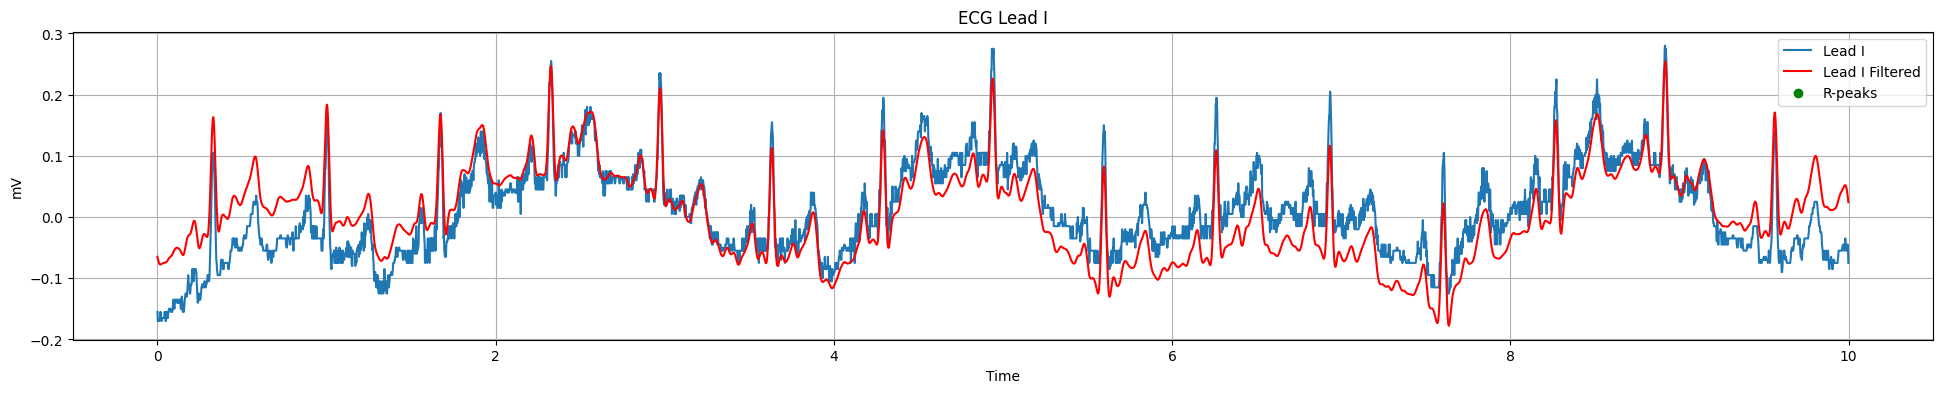

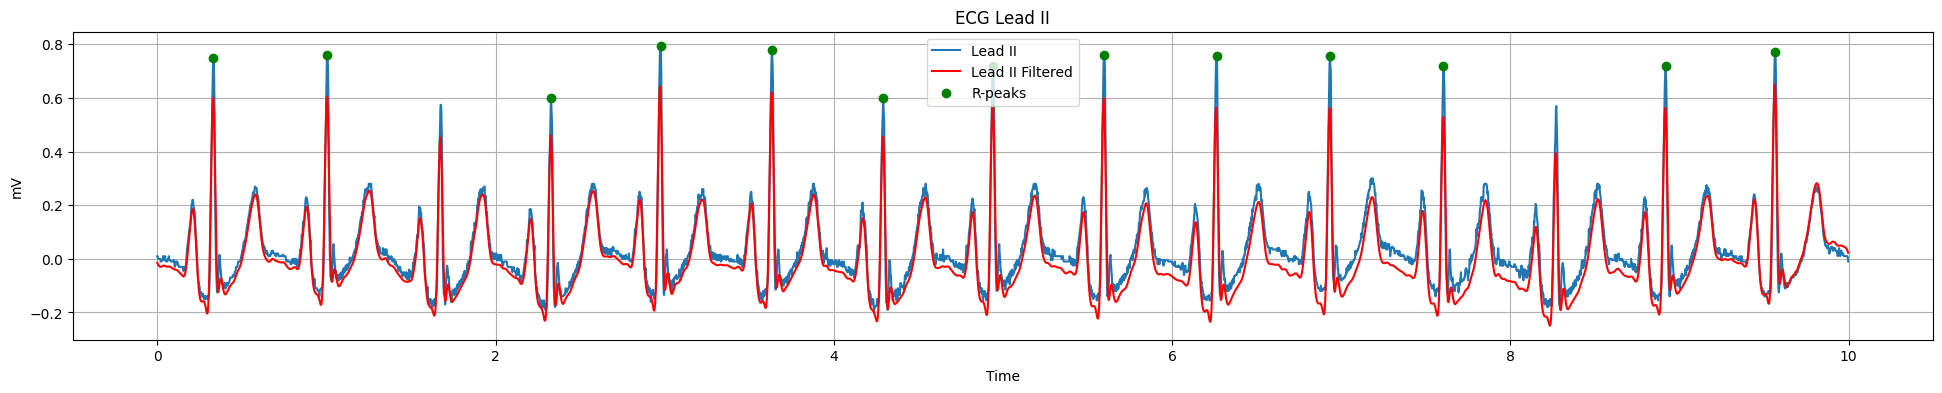

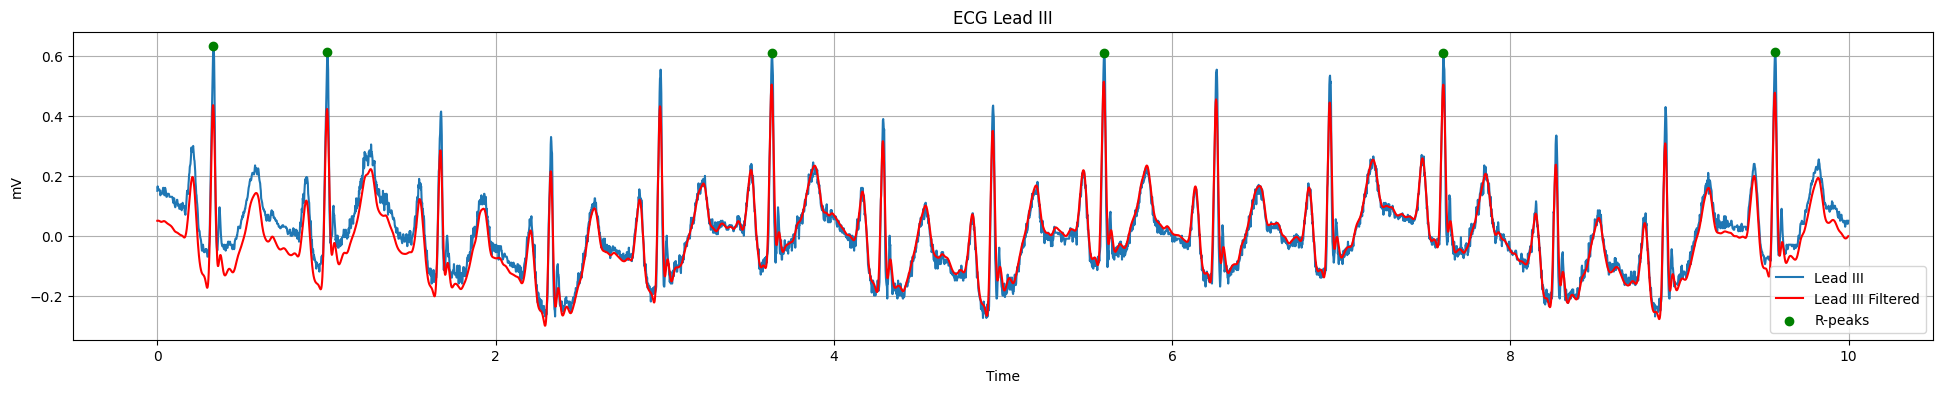

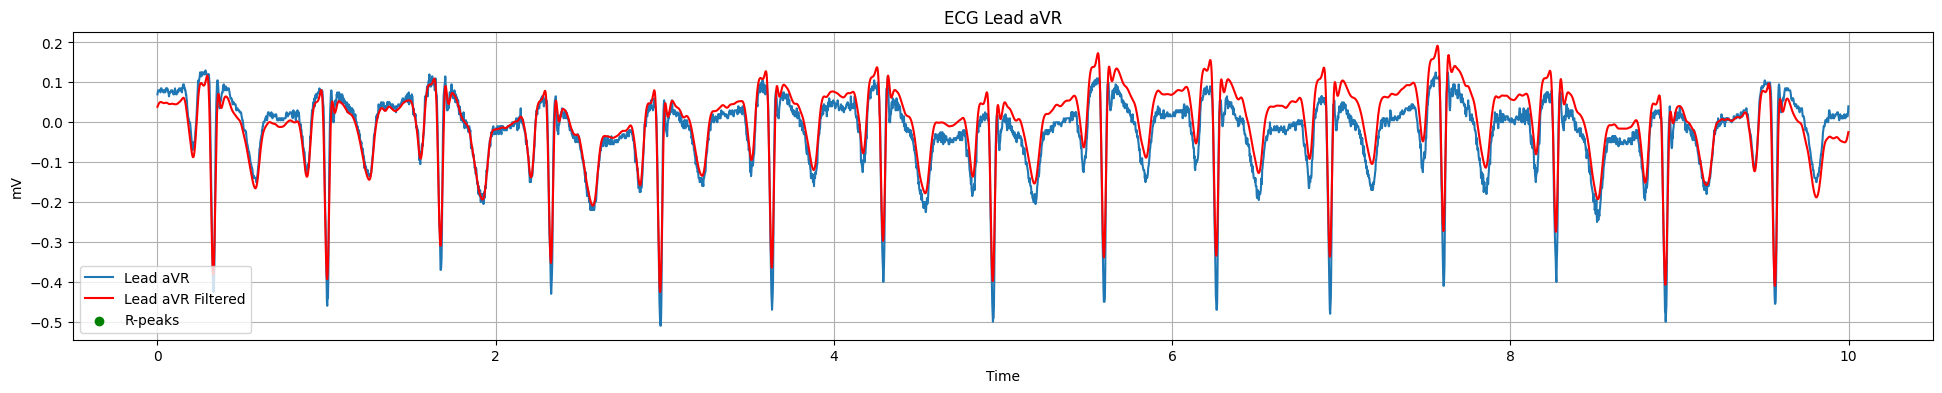

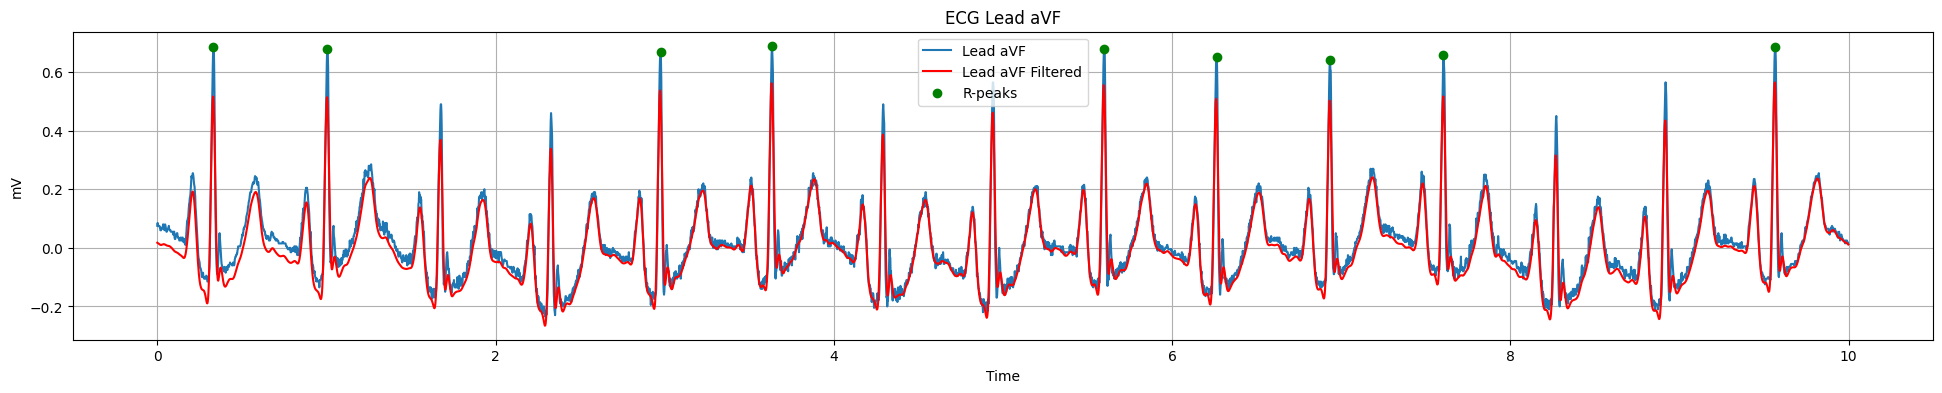

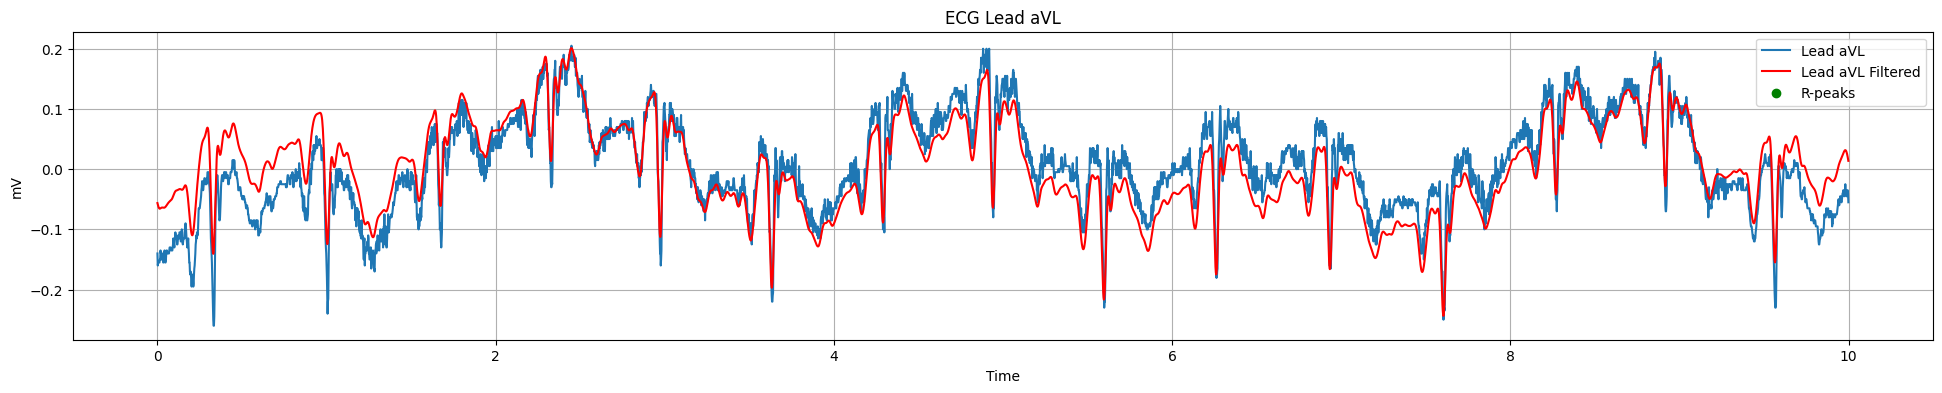

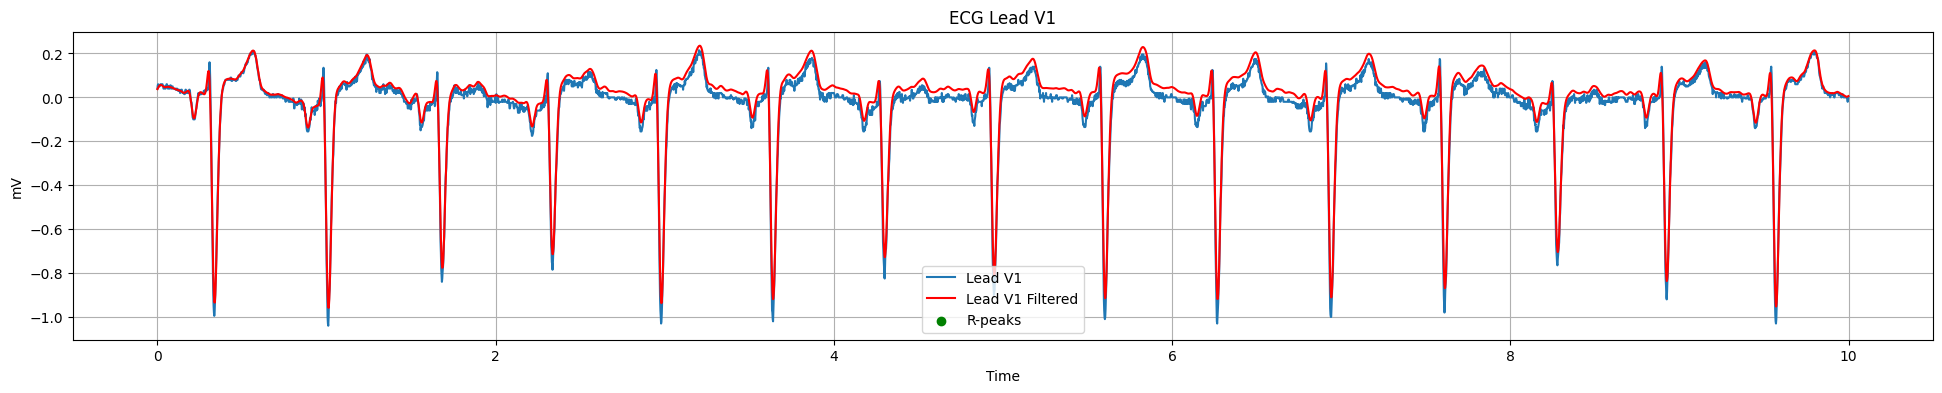

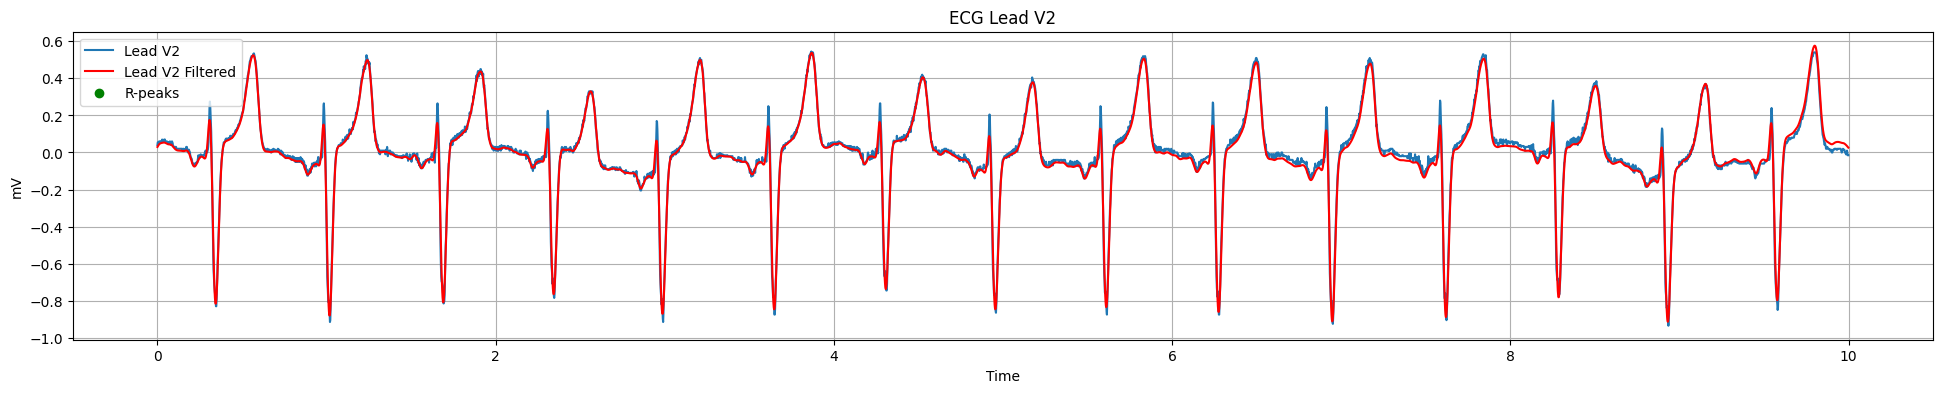

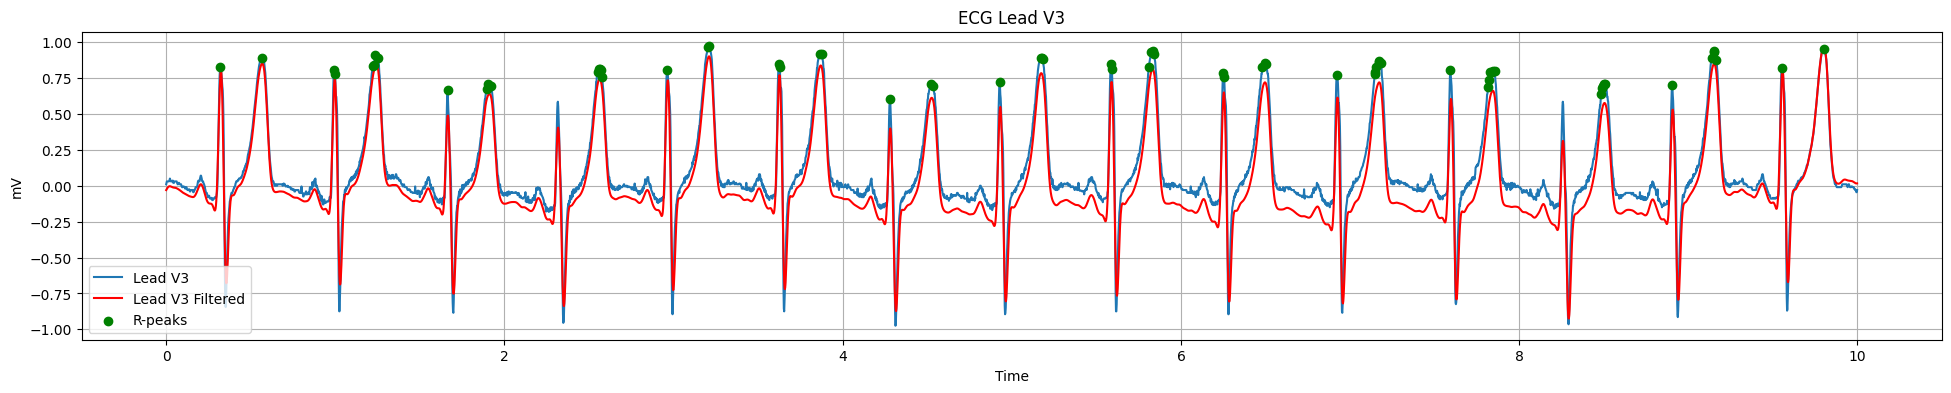

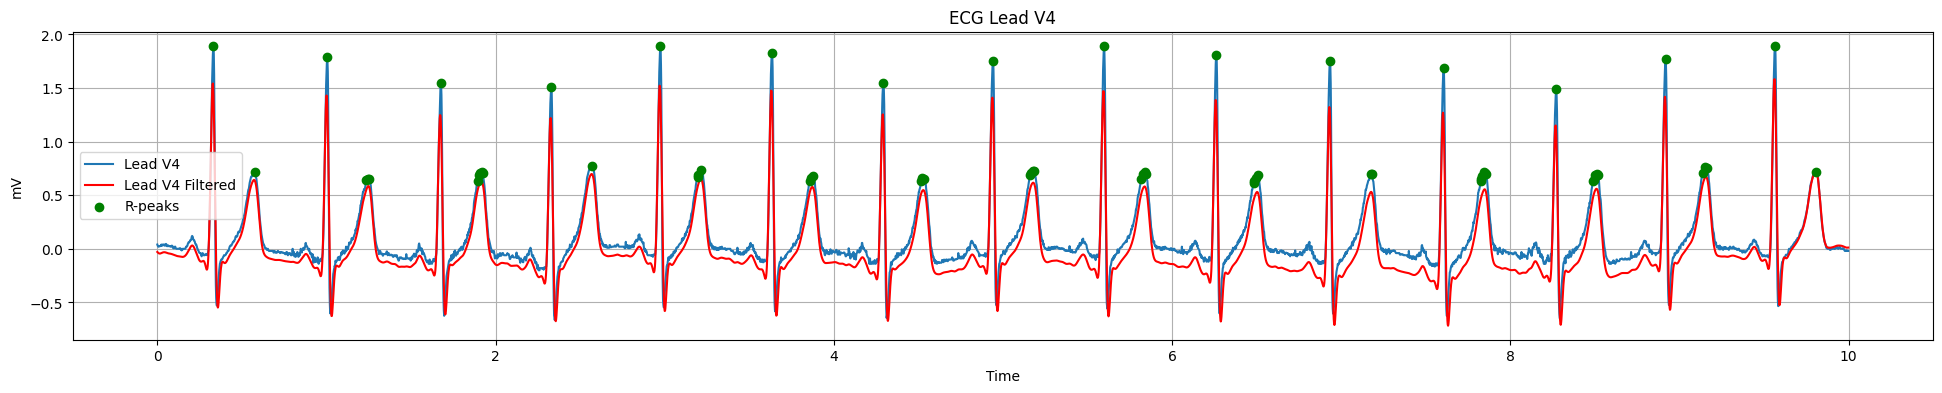

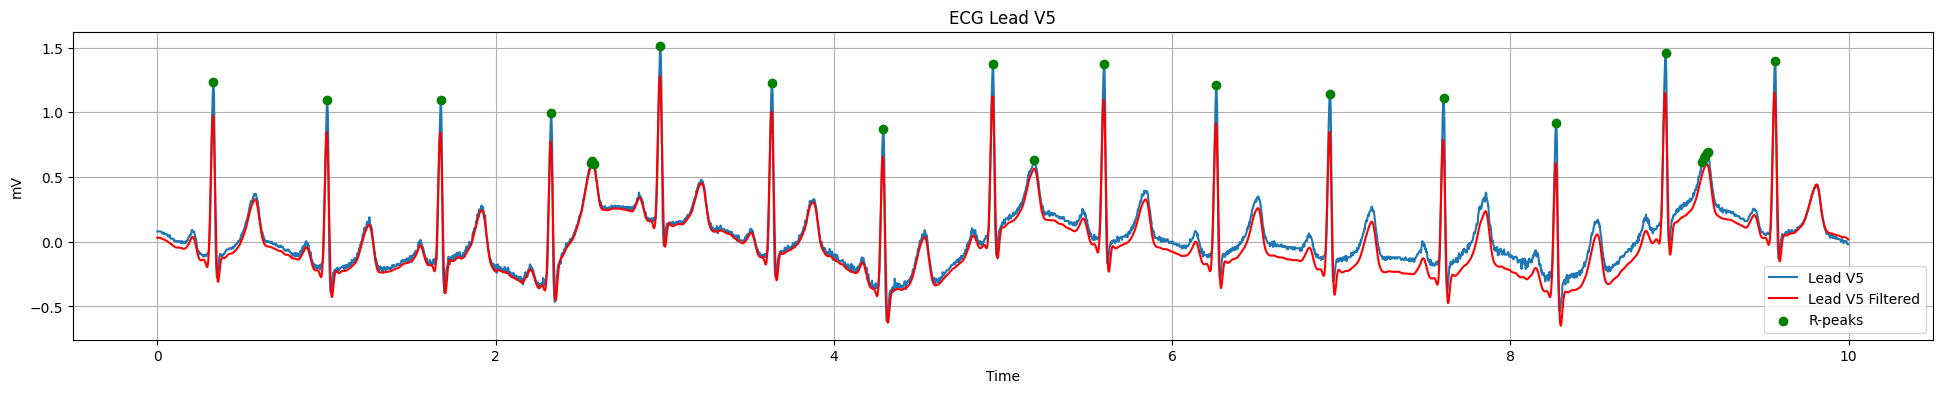

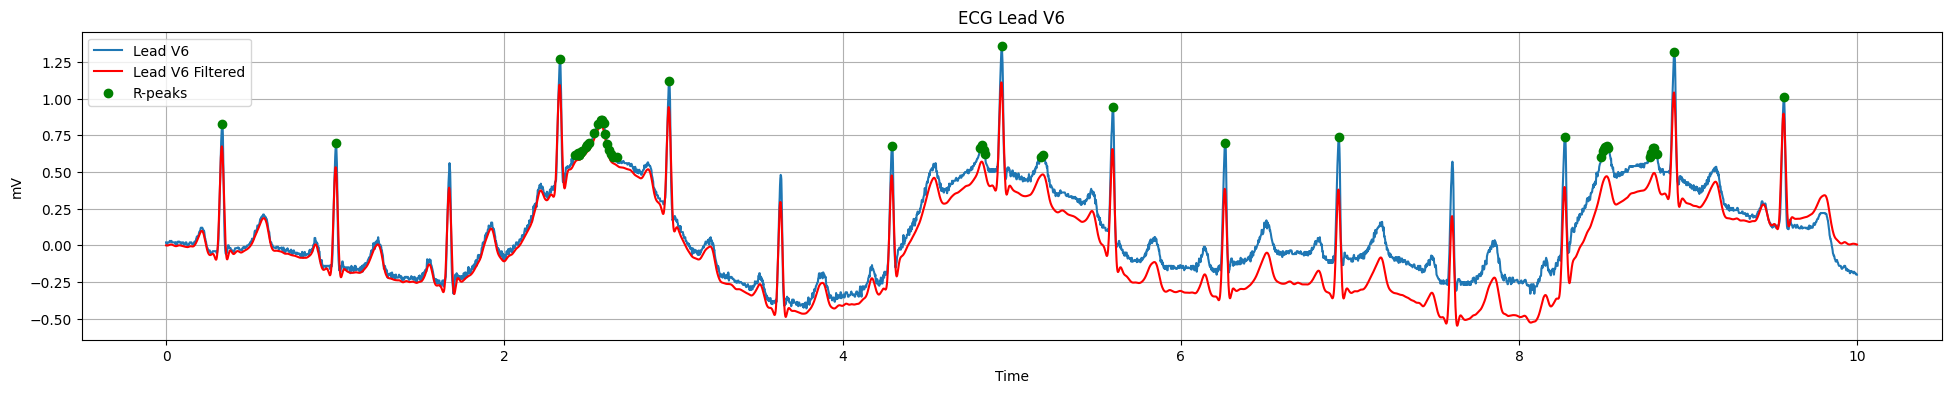

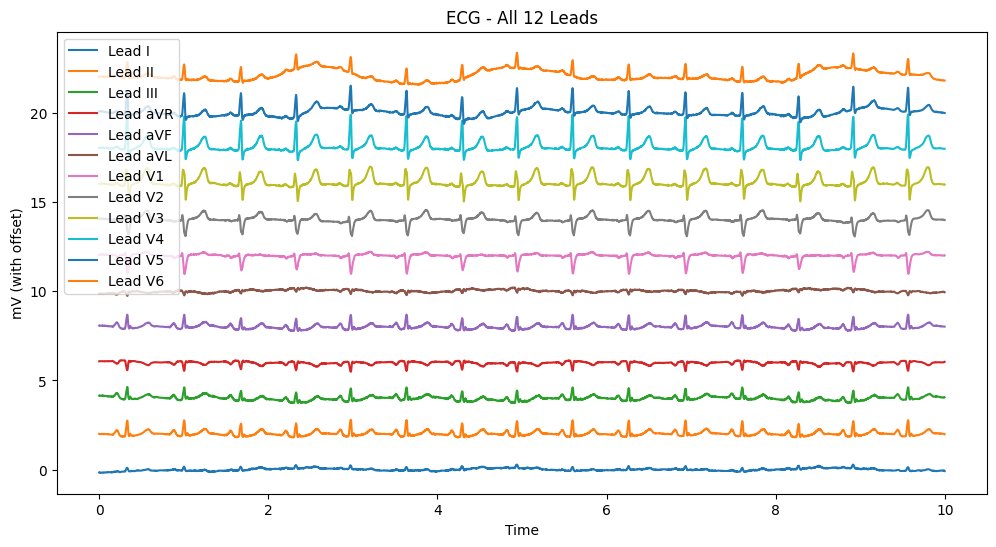

In [12]:
def calculate_amplitude(ecg_signal):
    max_amplitude = np.max(ecg_signal)
    min_amplitude = np.min(ecg_signal)
    peak_to_peak = max_amplitude - min_amplitude
    return max_amplitude, min_amplitude, peak_to_peak

# Calculate and print amplitudes for each lead
print(f"Amplitude of each lead: Sample-rate: 500 Hz, Sample-count: 5000 samples in 10 seconds")
print("-----------------------------------------------------------------------------")
for i in range(channel_count):
    max_amp, min_amp, p2p_amp = calculate_amplitude(mv_signal[i])
    print(f"Lead {channel_names[i]}: Max Amp = {max_amp:.3f} mV, Min Amp = {min_amp:.3f} mV, Peak-to-Peak Amp = {p2p_amp:.3f} mV")


# Tipically sample count is 5000 and the frequency is 500 Hz
# Create a time axis (in seconds) for the samples.
time = np.arange(sample_count) / frequency

# Plot each lead
for i in range(channel_count):
    plt.figure(figsize=(24, 4))
    plt.plot(time, mv_signal[:, i], label=f'Lead {channel_names[i]}')
    plt.plot(time, filtered_signals[:, i], color="red", label=f'Lead {channel_names[i]} Filtered')

    r_peaks = detect_r_peaks(mv_signal[:, i])
    plt.scatter(time[r_peaks], mv_signal[r_peaks, i], color='g', label='R-peaks', zorder=5)

    plt.title(f"ECG Lead {channel_names[i]}")
    plt.xlabel("Time")
    plt.ylabel("mV")

    plt.legend()
    plt.grid(True)
    plt.show()

plt.figure(figsize=(12, 6))
for i in range(channel_count):
    plt.plot(time, mv_signal[:, i] + i * 2, label=f'Lead {channel_names[i]}')

plt.legend()
plt.title("ECG - All 12 Leads")
plt.xlabel("Time")
plt.ylabel("mV (with offset)")


plt.show()

# Signal closeup

A closeup for 2 - 4 seconds into the ecg signal. This shows how the filter is affecting the sample in a closer look for short time intervals.

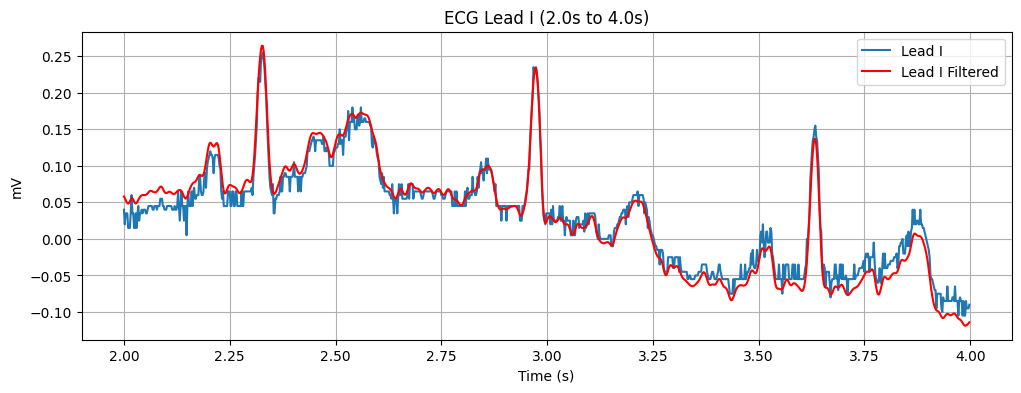

Lead I


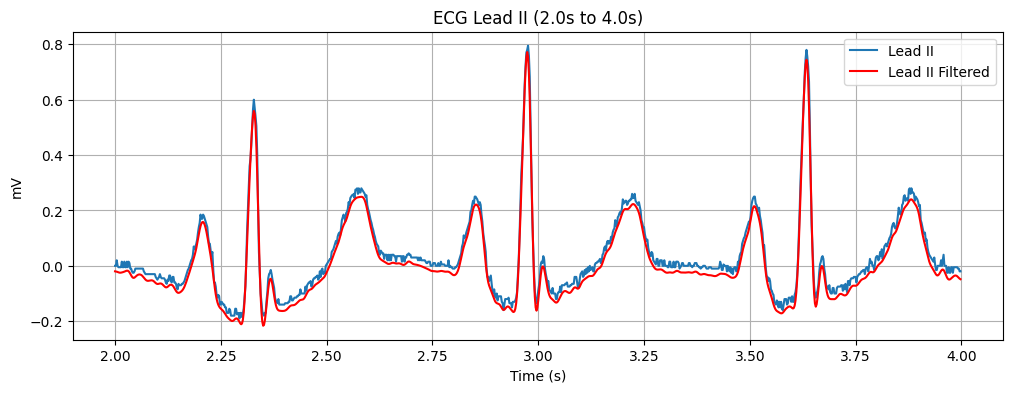

Lead II


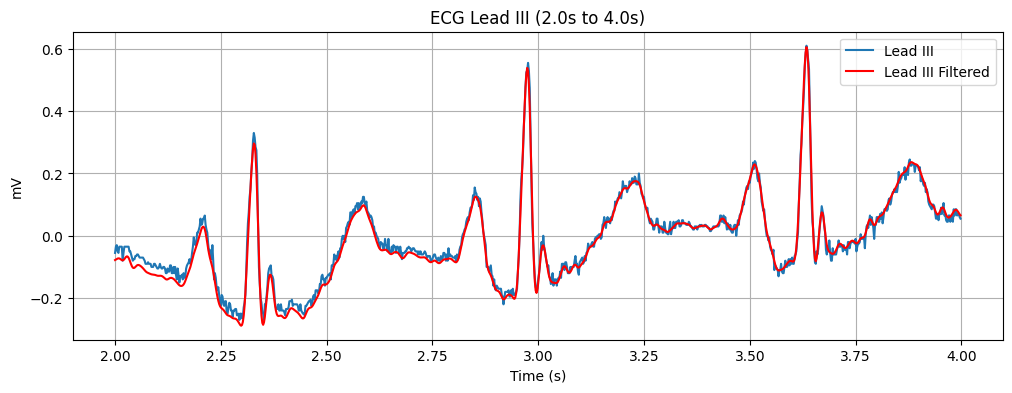

Lead III


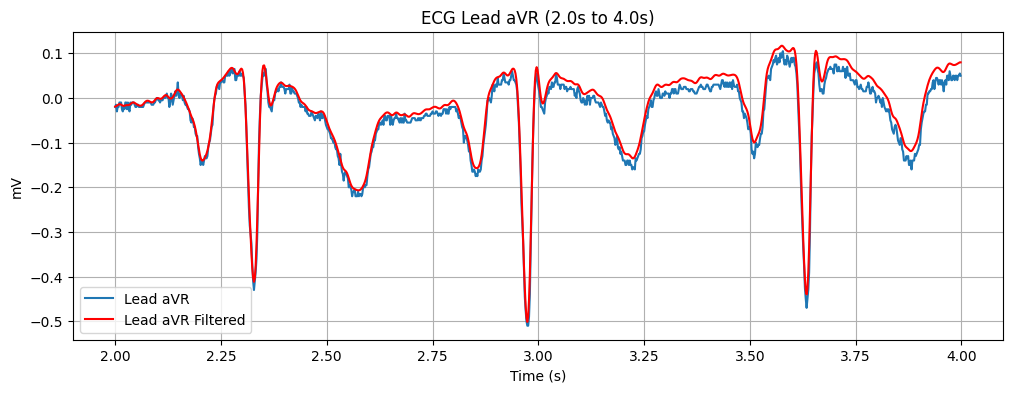

Lead aVR


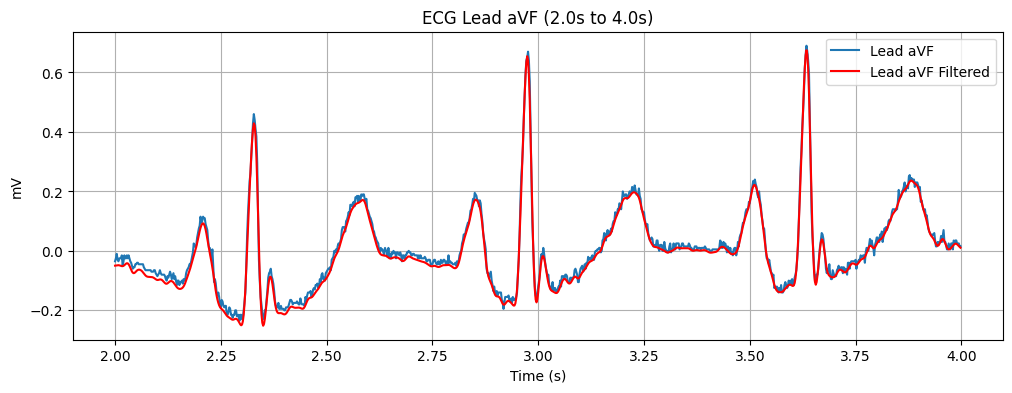

Lead aVF


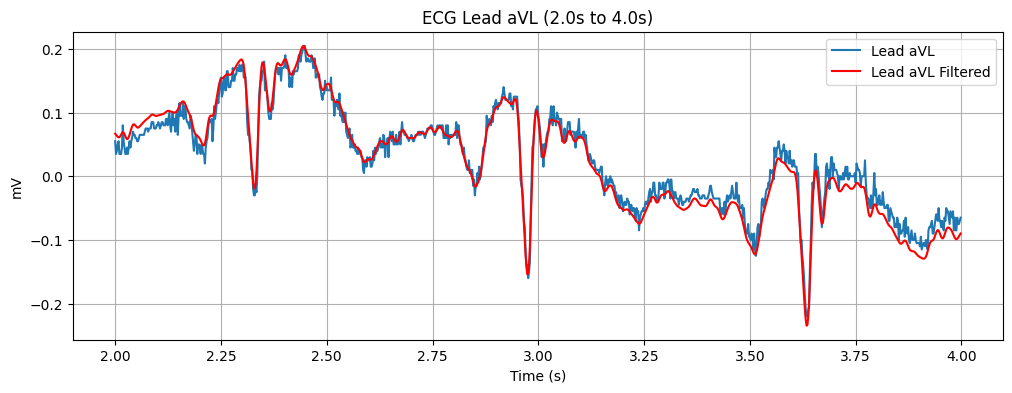

Lead aVL


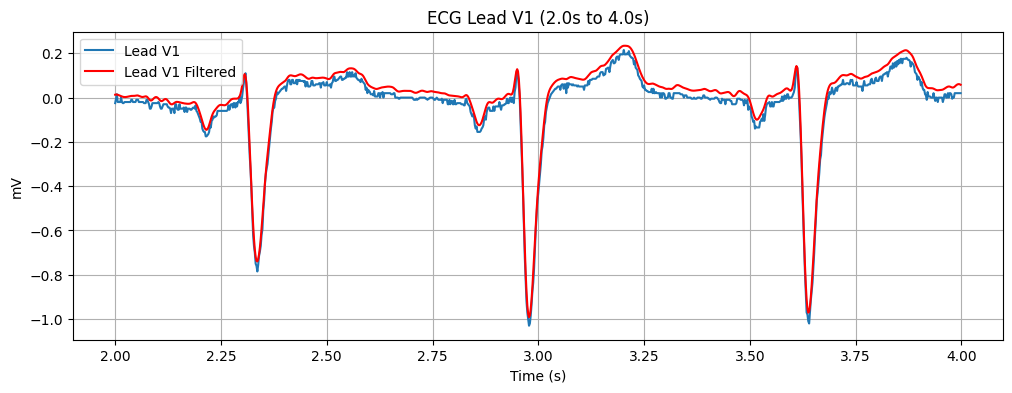

Lead V1


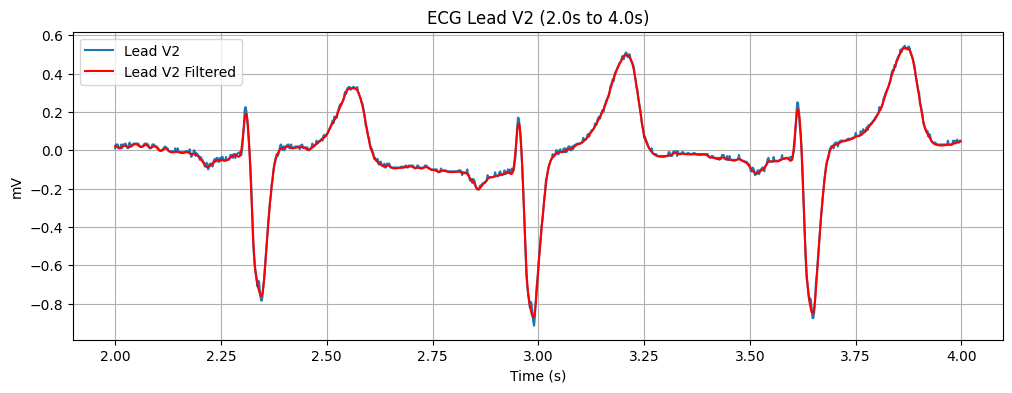

Lead V2


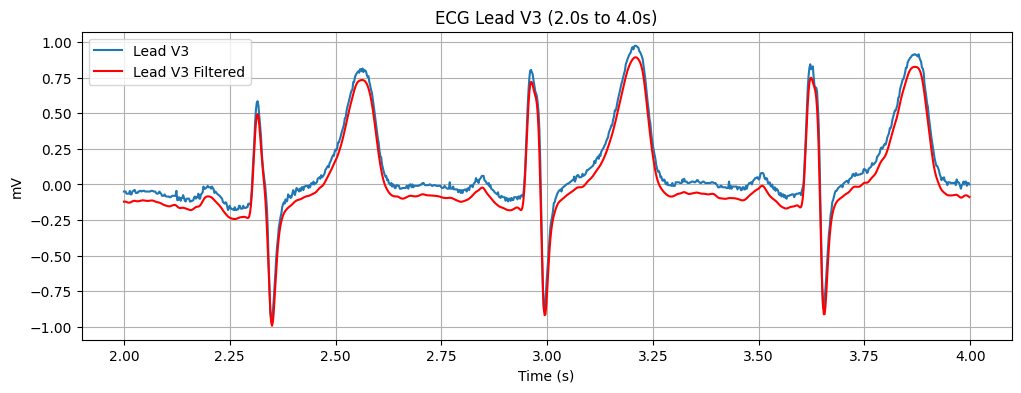

Lead V3


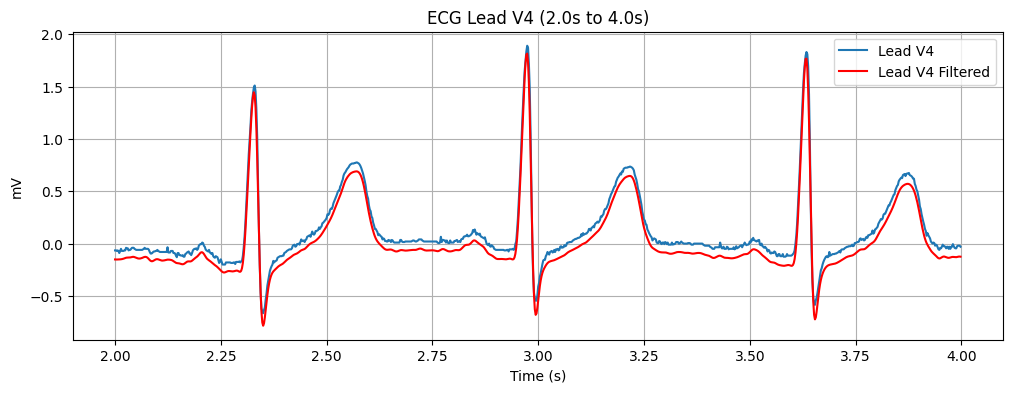

Lead V4


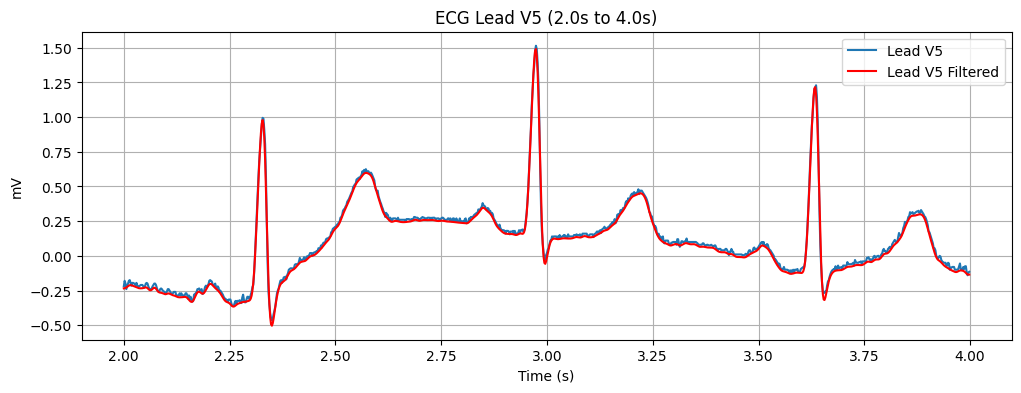

Lead V5


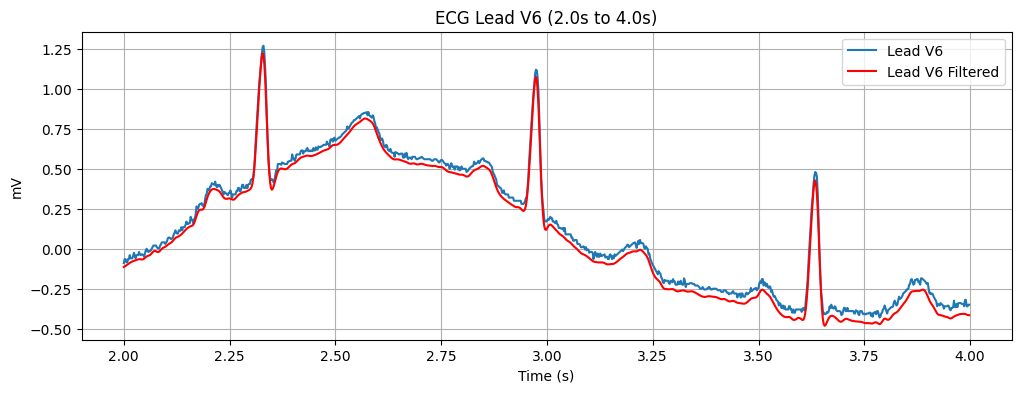

Lead V6


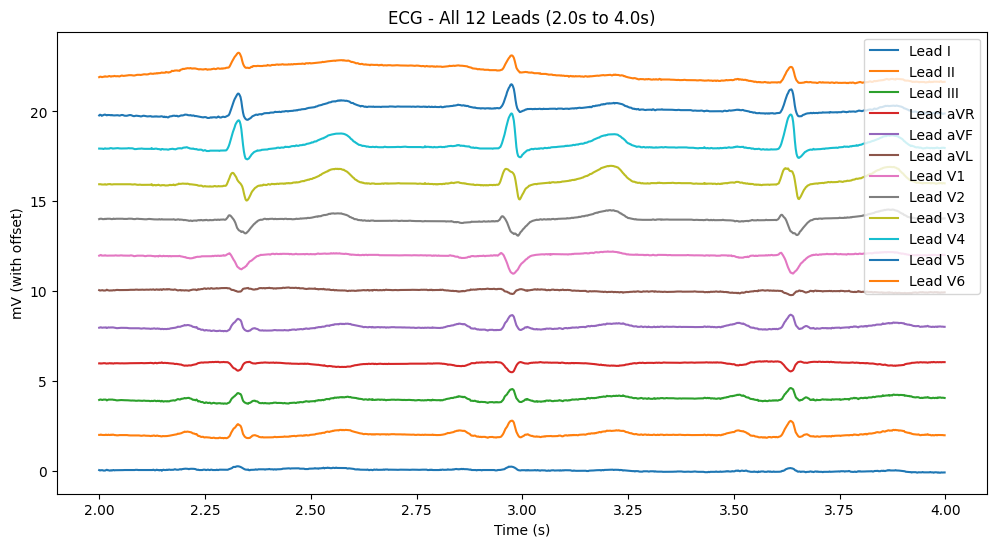

In [13]:
# Define time range (in seconds)
t1, t2 = 2.0, 4.0 

# Convert to indices
start_idx = int(t1 * frequency)
end_idx = int(t2 * frequency)

# Apply filtering and baseline removal
filtered_signals = bandpass_filter_mimic(mv_signal, lowcut=0.1, highcut=50.0)

# Extract the portion of the signal and time
time_range = time[start_idx:end_idx]
ecg_segment = mv_signal[start_idx:end_idx, :]
filtered_segment = filtered_signals[start_idx:end_idx, :]

# Heart rate calculation
for i in range(channel_count):
    plt.figure(figsize=(12, 4))
    plt.plot(time_range, ecg_segment[:, i], label=f'Lead {channel_names[i]}')
    plt.plot(time_range, filtered_segment[:, i], color="red", label=f'Lead {channel_names[i]} Filtered')

    # Detect R-peaks
    r_peaks = detect_r_peaks(ecg_segment[:, i])
    r_peak_times = time_range[r_peaks] 

    plt.title(f"ECG Lead {channel_names[i]} ({t1}s to {t2}s)")
    plt.xlabel("Time (s)")
    plt.ylabel("mV")
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"Lead {channel_names[i]}")

# Plot all leads together in selected time range
plt.figure(figsize=(12, 6))
for i in range(channel_count):
    plt.plot(time_range, ecg_segment[:, i] + i * 2, label=f'Lead {channel_names[i]}')

plt.legend()
plt.title(f"ECG - All 12 Leads ({t1}s to {t2}s)")
plt.xlabel("Time (s)")
plt.ylabel("mV (with offset)")
plt.show()
